## Imports and Set Up 

In [1]:
!ln -vs /sw/arcts/centos7/stacks/gcc/8.2.0/gdal/3.0.1/lib/libgdal.so* ./

ln: failed to create symbolic link ‘./libgdal.so’: File exists
ln: failed to create symbolic link ‘./libgdal.so.26’: File exists
ln: failed to create symbolic link ‘./libgdal.so.26.0.1’: File exists


In [2]:
import gdal
import osgeo
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
from shapely.geometry import mapping
import os 

In [3]:
cd /scratch/si699s004w21_class_root/si699s004w21_class/shared_data/Team_10/noaa_pulls

/gpfs/accounts/si699s004w21_class_root/si699s004w21_class/shared_data/Team_10/noaa_pulls


## Formatting the Shapefile. Preparing to Mask with Rasters 

In [7]:
## shapefile 
#Open up our shapefile and check its crs
shapefile = gpd.read_file("/home/elizbr/DallasCountyBoundary.zip")#, encoding="utf-8")
shapefile.crs

#Remember the projections don't match! Let's use some geopandas magic to 
#reproject all our shapefiles to lat, long.
shapefile = shapefile.to_crs({'init': 'epsg:4326'})
shapefile.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
#Now we want to extract the geometry of each feature in the shapefile 
#in GeoJSON format:

# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((-96.51701533519065 32.98286651062318, -96.51816517875432 32.89336885359012, -96.51889281413446 32.8154758252503, -96.51971926419586 32.74711791653727, -96.52253997418799 32.58425578513664, -96.52129131594306 32.5566390613162, -96.52147097899989 32.54500842350607, -96.58692223060082 32.54569752021592, -96.74607674948828 32.54666679015235, -96.78951029347546 32.54705298072722, -96.87411362693383 32.54746945889708, -96.89356215283503 32.54741645269186, -96.90619246572975 32.54761333272491, -96.95438708072277 32.54776477861036, -97.01267875950928 32.54847657084967, -97.03869397013737 32.54864315970768, -97.03440900623212 32.80738981048831, -97.03107625652804 32.98966315146451, -96.77035821161805 32.98648341346427, -96.51701533519065 32.98286651062318))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((-96.51701533519065, 32.982866510623175), (-96.51816517875432, 32.89336885359012), (-96.51889281413446, 32.815475825250296), (-96.51971

## Looping Through NOAA_pulls and saving out Cropped .TIFS to Work With 

In [44]:
path = "/gpfs/accounts/si699s004w21_class_root/si699s004w21_class/shared_data/Team_10/noaa_pulls/"

for file in os.listdir('/gpfs/accounts/si699s004w21_class_root/si699s004w21_class/shared_data/Team_10/noaa_pulls/'):
    #print(file)
    filename = path + file
    ## raster mask 
    try: 
        with rasterio.open(filename) as src:
            #print('one')
            try: 
                out_image, out_transform = mask(src, feature, crop=True)
                #out_image.shape
                meta = src.meta

                meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})

                saving_path = "/home/elizbr/noaa_Crop/" + file
                with rasterio.open(saving_path, "w", **meta) as dest:
                    dest.write(out_image)
            except:
                print(f"Cannot Read: {file}")
    except:
        pass

In [47]:
path = "/gpfs/accounts/si699s004w21_class_root/si699s004w21_class/shared_data/Team_10/noaa_pulls/data_2015to2017/tif_data"

for file in os.listdir('/gpfs/accounts/si699s004w21_class_root/si699s004w21_class/shared_data/Team_10/noaa_pulls/data_2015to2017/tif_data'):
    #print(file)
    filename = path + file
    ## raster mask 
    try:
        with rasterio.open(filename) as src:
            #print('one')
            try: 
                out_image, out_transform = mask(src, feature, crop=True)
                #out_image.shape
                meta = src.meta

                meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})

                saving_path = "/home/elizbr/noaa_Crop/" + file
                with rasterio.open(saving_path, "w", **meta) as dest:
                    dest.write(out_image)
            except:
                print(f"Cannot Read: {file}")
    except:
        pass

## Quality Check
Here I am going into the cropped raster tifs to print out some information and be sure its saved out correctly. 

Pixel wise we have 126 wide X 108 high. 

In [49]:
## raster mask 
sample = gdal.Open(r'/home/elizbr/noaa_Crop/SVDNB_npp_20200601-20200630_75N180W_vcmslcfg_v10_c202008012300.avg_rade9h.tif')
print(sample.RasterCount)

# width 
print(sample.RasterXSize)

# height
print(sample.RasterYSize)

1
126
108


In [51]:
# i am only finding one band 
band1 = sample.GetRasterBand(1) #blue 
b1 = band1.ReadAsArray()

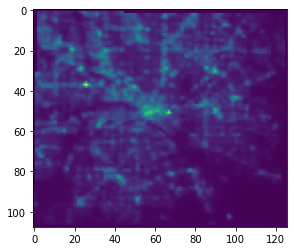

In [53]:
import matplotlib.pyplot as plt
from rasterio.plot import show

#img = np.dstack((b1))
f = plt.figure()
plt.imshow(b1)